# Data
## EDA
### Projects

In [1]:
from collections import Counter
import ipywidgets as widgets
import itertools
import json
import pandas as pd
from urllib.request import urlopen

In [2]:
# Load projects
url = "https://raw.githubusercontent.com/GokuMohandas/Made-With-ML/main/datasets/projects.json"
projects = json.loads(urlopen(url).read())
print (f"{len(projects)} projects")
print (json.dumps(projects[0], indent=2))

955 projects
{
  "id": 6,
  "created_on": "2020-02-20 06:43:18",
  "title": "Comparison between YOLO and RCNN on real world videos",
  "description": "Bringing theory to experiment is cool. We can easily train models in colab and find the results in minutes.",
  "tag": "computer-vision"
}


In [3]:
# Create dataframe
df = pd.DataFrame(projects)
print (f"{len(df)} projects")
df.head(5)

955 projects


id           created_on                                              title  \
0   6  2020-02-20 06:43:18  Comparison between YOLO and RCNN on real world...   
1   7  2020-02-20 06:47:21  Show, Infer & Tell: Contextual Inference for C...   
2   9  2020-02-24 16:24:45                       Awesome Graph Classification   
3  15  2020-02-28 23:55:26                    Awesome Monte Carlo Tree Search   
4  19  2020-03-03 13:54:31                                Diffusion to Vector   

                                         description                     tag  
0  Bringing theory to experiment is cool. We can ...         computer-vision  
1  The beauty of the work lies in the way it arch...         computer-vision  
2  A collection of important graph embedding, cla...          graph-learning  
3  A curated list of Monte Carlo tree search pape...  reinforcement-learning  
4  Reference implementation of Diffusion2Vec (Com...          graph-learning

In [4]:
# 1. remove projects with no tag
df = df[df.tag.notnull()]

In [5]:
# 2. Most common tags
tags = Counter(df.tag.values)
tags.most_common()

[('natural-language-processing', 388),
 ('computer-vision', 356),
 ('mlops', 79),
 ('reinforcement-learning', 56),
 ('graph-learning', 45),
 ('time-series', 31)]

### Tags

In [6]:
# Load tags
url = "https://raw.githubusercontent.com/GokuMohandas/Made-With-ML/main/datasets/tags.json"
tags_dict = {}
for item in json.loads(urlopen(url).read()):
    key = item.pop("tag")
    tags_dict[key] = item
print (f"{len(tags_dict)} tags")


4 tags


In [7]:
@widgets.interact(tag=list(tags_dict.keys()))
def display_tag_details(tag="computer-vision"):
    print (json.dumps(tags_dict[tag], indent=2))


interactive(children=(Dropdown(description='tag', options=('computer-vision', 'graph-learning', 'mlops', 'natu‚Ä¶

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from wordcloud import WordCloud, STOPWORDS
sns.set_theme()
warnings.filterwarnings("ignore")

### Tag Distribution

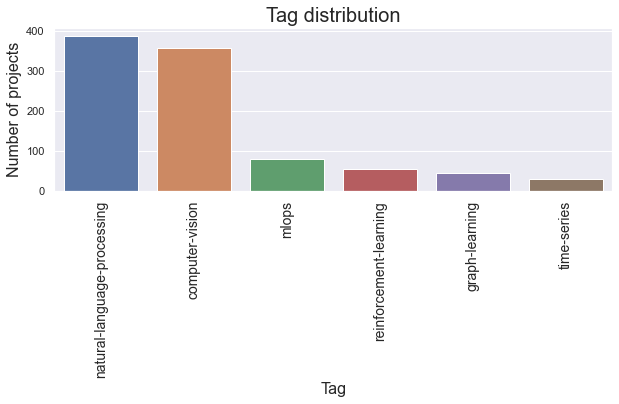

In [9]:
tags, tag_counts = zip(*Counter(df.tag.values).most_common())
plt.figure(figsize=(10, 3))
ax = sns.barplot(list(tags), list(tag_counts))
plt.title("Tag distribution", fontsize=20)
plt.xlabel("Tag", fontsize=16)
ax.set_xticklabels(tags, rotation=90, fontsize=14)
plt.ylabel("Number of projects", fontsize=16)
plt.show()

### Wordcloud

In [10]:
@widgets.interact(tag=list(tags))
def display_word_cloud(tag="natural-language-processing", column_name = 'title'):
    plt.figure(figsize=(15, 5))
    subset = df[df.tag == tag]
    text = subset[column_name].values
    cloud = WordCloud(
        stopwords=STOPWORDS, background_color="black", collocations=False,
        width=500, height=300).generate(" ".join(text))
    plt.axis("off")
    plt.imshow(cloud)
    

interactive(children=(Dropdown(description='tag', options=('natural-language-processing', 'computer-vision', '‚Ä¶

## Data Labeling
- if a data point has a tag that we currently don't support, we'll replace it with `other`
- if a certain tag doesn't have enough samples, we'll replace it with `other`

In [11]:
# Out of scope (OOS) tags 
oos_tags = [item for item in df.tag.unique() if item not in tags_dict.keys()]
oos_tags

['reinforcement-learning', 'time-series']

In [12]:
oos_indices = df[df.tag.isin(oos_tags)].index
df.iloc[oos_indices].head()

id           created_on                                       title  \
3    15  2020-02-28 23:55:26             Awesome Monte Carlo Tree Search   
37  121  2020-03-24 04:56:38  Deep Reinforcement Learning in TensorFlow2   
67  218  2020-04-06 11:29:57         Distributional RL using TensorFlow2   
74  239  2020-04-06 18:39:48               Prophet: Forecasting At Scale   
95  277  2020-04-07 00:30:33       Curriculum for Reinforcement Learning   

                                          description                     tag  
3   A curated list of Monte Carlo tree search pape...  reinforcement-learning  
37  deep-rl-tf2 is a repository that implements a ...  reinforcement-learning  
67  üê≥ Implementation of various Distributional Rei...  reinforcement-learning  
74  Tool for producing high quality forecasts for ...             time-series  
95  Curriculum learning applied to reinforcement l...  reinforcement-learning

In [13]:
df.loc[oos_indices, ['tag']] = ["other"]

In [14]:
df.head()

id           created_on                                              title  \
0   6  2020-02-20 06:43:18  Comparison between YOLO and RCNN on real world...   
1   7  2020-02-20 06:47:21  Show, Infer & Tell: Contextual Inference for C...   
2   9  2020-02-24 16:24:45                       Awesome Graph Classification   
3  15  2020-02-28 23:55:26                    Awesome Monte Carlo Tree Search   
4  19  2020-03-03 13:54:31                                Diffusion to Vector   

                                         description              tag  
0  Bringing theory to experiment is cool. We can ...  computer-vision  
1  The beauty of the work lies in the way it arch...  computer-vision  
2  A collection of important graph embedding, cla...   graph-learning  
3  A curated list of Monte Carlo tree search pape...            other  
4  Reference implementation of Diffusion2Vec (Com...   graph-learning

In [15]:
min_freq = 75
tags = Counter(df.tag.values)
print(tags)

Counter({'natural-language-processing': 388, 'computer-vision': 356, 'other': 87, 'mlops': 79, 'graph-learning': 45})


In [16]:
@widgets.interact(min_freq=(0, tags.most_common()[0][1]+1))
def separate_tags_by_feq(min_freq=min_freq):
    tags_above_freq = Counter(tag for tag in tags.elements() if tags[tag] >= min_freq)
    tags_below_freq = Counter(tag for tag in tags.elements() if tags[tag] < min_freq)
    print ("Most popular tags:\n", tags_above_freq.most_common(3))
    print ("\nTags that just made the cut:\n", tags_above_freq.most_common()[-3:])
    print ("\nTags that just missed the cut:\n", tags_below_freq.most_common(3))

interactive(children=(IntSlider(value=75, description='min_freq', max=389), Output()), _dom_classes=('widget-i‚Ä¶

In [17]:
def filter(tag, include=[]):
    """Determine if a given tag is to be included

    Args:
        tag (_type_): _description_
        include (list, optional): _description_. Defaults to [].
    """    
    if tag in include:
        return tag

In [18]:
tags_above_freq = Counter(tag for tag in tags.elements() if tags[tag] >= min_freq)
df.tag = df.tag.apply(filter, include=list(tags_above_freq.keys()))

In [19]:
df.head()

id           created_on                                              title  \
0   6  2020-02-20 06:43:18  Comparison between YOLO and RCNN on real world...   
1   7  2020-02-20 06:47:21  Show, Infer & Tell: Contextual Inference for C...   
2   9  2020-02-24 16:24:45                       Awesome Graph Classification   
3  15  2020-02-28 23:55:26                    Awesome Monte Carlo Tree Search   
4  19  2020-03-03 13:54:31                                Diffusion to Vector   

                                         description              tag  
0  Bringing theory to experiment is cool. We can ...  computer-vision  
1  The beauty of the work lies in the way it arch...  computer-vision  
2  A collection of important graph embedding, cla...             None  
3  A curated list of Monte Carlo tree search pape...            other  
4  Reference implementation of Diffusion2Vec (Com...             None

In [20]:
df.tag = df.tag.fillna("other")

In [21]:
from snorkel.labeling import labeling_function

@labeling_function()
def contains_tensorflow(text):
    condition = any(tag in text.lower() for tag in ("tensorflow", "tf"))
    return "tensorflow" if condition else None

## Preprocessing

### Feature engineering

In [22]:
df.head()

id           created_on                                              title  \
0   6  2020-02-20 06:43:18  Comparison between YOLO and RCNN on real world...   
1   7  2020-02-20 06:47:21  Show, Infer & Tell: Contextual Inference for C...   
2   9  2020-02-24 16:24:45                       Awesome Graph Classification   
3  15  2020-02-28 23:55:26                    Awesome Monte Carlo Tree Search   
4  19  2020-03-03 13:54:31                                Diffusion to Vector   

                                         description              tag  
0  Bringing theory to experiment is cool. We can ...  computer-vision  
1  The beauty of the work lies in the way it arch...  computer-vision  
2  A collection of important graph embedding, cla...            other  
3  A curated list of Monte Carlo tree search pape...            other  
4  Reference implementation of Diffusion2Vec (Com...            other

In [23]:
df['text'] = df.title + " " + df.description

In [24]:
df.head()

id           created_on                                              title  \
0   6  2020-02-20 06:43:18  Comparison between YOLO and RCNN on real world...   
1   7  2020-02-20 06:47:21  Show, Infer & Tell: Contextual Inference for C...   
2   9  2020-02-24 16:24:45                       Awesome Graph Classification   
3  15  2020-02-28 23:55:26                    Awesome Monte Carlo Tree Search   
4  19  2020-03-03 13:54:31                                Diffusion to Vector   

                                         description              tag  \
0  Bringing theory to experiment is cool. We can ...  computer-vision   
1  The beauty of the work lies in the way it arch...  computer-vision   
2  A collection of important graph embedding, cla...            other   
3  A curated list of Monte Carlo tree search pape...            other   
4  Reference implementation of Diffusion2Vec (Com...            other   

                                                text  
0  Comparison between YOLO and RCNN on real world...  
1  Show, Infer & Tell: Contextual Inference for C...  
2  Awesome Graph Classification A collection of i...  
3  Awesome Monte Carlo Tree Search A curated list...  
4  Diffusion to Vector Reference implementation o...

### Cleaning

In [25]:
%pip install nltk==3.7 -q

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Program Files\Python38\python.exe -m pip install --upgrade pip' command.


In [26]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re

In [27]:
nltk.download("stopwords")
STOPWORDS = stopwords.words("english")
stemmer = PorterStemmer()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\soham\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [28]:
def clean_text(text, lower=True, stem=False, stopwords=STOPWORDS):
    """Clean raw text

    Args:
        text (str): _description_
        lower (bool, optional): _description_. Defaults to True.
        stem (bool, optional): _description_. Defaults to False.
        stopwords (_type_, optional): _description_. Defaults to STOPWORDS.
    """
    if lower:
        text = text.lower()

    if len(stopwords):
        pattern = re.compile(r'\b(' + r"|".join(stopwords) + r")\b\s*")
        # NOTE: above regex \b... searches for "..." at the beginning of a word
        # "...\b" searches for "..." at the end of a word
        # "\s" searches for whitespace characters
        # "*" searches for zero or more occurrences of preceeding text
        text = pattern.sub('', text)
    
    text = re.sub(
        r"([!\"'#$%&()*\+,-./:;<=>?@\\\[\]^_`{|}~])", r" \1 ", text
    )  # add spacing between objects to be filtered
    text = re.sub("[^A-Za-z0-9]+", " ", text)  # remove non alphanumeric chars, "[^...]" - not containing "..."
    text = re.sub(" +", " ", text)  # remove multiple spaces
    text = text.strip()  # strip white space at the ends

    # Remove links
    text = re.sub(r"http\S+", "", text)

    if stem:
        text = " ".join([stemmer.stem(word, to_lowercase=lower) for word in text.split(" ")])
    
    return text

In [29]:
# Toggle preprocessing parameters
@widgets.interact(lower=True, stem=False)
def display_cleaned_text(lower, stem):
    text = "Conditional image generation using Variational Autoencoders and GANs. 12 #$  ! @.fv ronb wo2in3r"
    cleaned_text = clean_text(text=text, lower=lower, stem=stem)
    print (cleaned_text)    

interactive(children=(Checkbox(value=True, description='lower'), Checkbox(value=False, description='stem'), Ou‚Ä¶

In [30]:
# Apply to dataframe
original_df = df.copy()
df.text = df.text.apply(clean_text, lower=True, stem=False)
print (f"{original_df.text.values[0]}\n{df.text.values[0]}")


Comparison between YOLO and RCNN on real world videos Bringing theory to experiment is cool. We can easily train models in colab and find the results in minutes.
comparison yolo rcnn real world videos bringing theory experiment cool easily train models colab find results minutes


### Encoding

In [31]:
import numpy as np
import random


In [32]:
df.tag.unique()

array(['computer-vision', 'other', 'natural-language-processing', 'mlops'],
      dtype=object)

In [33]:
X = df.text.to_numpy()
y = df.tag

In [34]:
class LabelEncoder():
    """Encode target labels `y` into unique indices between `0` and `n_classes-1`.
    """
    def __init__(self, class_to_index={}):
        self.class_to_index = class_to_index or {} # mutable defaults
        self.index_to_class = {v: k for k, v in self.class_to_index.items()}
        self.classes = list(self.class_to_index.keys())
    
    def __len__(self):
        return len(self.classes)
    
    def __str__(self):
        return f"<LabelEncoder(num_classes={len(self)})"
    
    def fit(self, y):
        classes = np.unique(y)
        self.index_to_class = {}
        for i, class_ in enumerate(classes):
            self.class_to_index[class_] = i
            self.index_to_class[i] = class_
        self.classes = list(self.class_to_index.keys())
        return self
    
    def encode(self, y):
        encoded = np.zeros((len(y)), dtype=int)
        for i, item in enumerate(y):
            encoded[i] = self.class_to_index[item]
        return encoded

    def decode(self, y):
        classes = []
        for i, item in enumerate(y):
            classes.append(self.index_to_class[item])
        return classes

    def save(self, fp):
        with open(fp, "w") as fp:
            contents = {"class_to_index": self.class_to_index}
            json.dump(contents, fp, indent=4, sort_keys=False)
    
    @classmethod
    def load(cls, fp):
        # A class method is LIKE a static function?
        # A class method is a method which is bound to the class and not the object of the class.
        # They have the access to the state of the class as it takes a class parameter that points to the class and not the object instance.
        # It can modify a class state that would apply across all the instances of the class. For example, it can modify a class variable that would be applicable to all the instances.
        with open(fp, "r") as fp:
            kwargs = json.load(fp=fp)
        return cls(**kwargs)

    

In [35]:
# Encode
label_encoder = LabelEncoder()
label_encoder.fit(y)
num_classes = len(label_encoder)


In [36]:
label_encoder.class_to_index


{'computer-vision': 0,
 'mlops': 1,
 'natural-language-processing': 2,
 'other': 3}

In [37]:
label_encoder.index_to_class


{0: 'computer-vision',
 1: 'mlops',
 2: 'natural-language-processing',
 3: 'other'}

In [38]:
# Encode
label_encoder.encode(["computer-vision", "mlops", "mlops"])


array([0, 1, 1])

In [39]:
# Decode
label_encoder.decode(np.array([0, 1, 1]))


['computer-vision', 'mlops', 'mlops']

In [40]:
# Encode all our labels
y = label_encoder.encode(y)
print (y.shape)


(955,)
